# Classification of exoplanets 

The goal of this project is to understand how exoplanets can be classified, and which of these classes resemble planets in our Solar System. 

The data is taken from [NASA exoplanet archive](https://exoplanetarchive.ipac.caltech.edu/index.html), and is retrieved with [pyvo library](https://pyvo.readthedocs.io/en/latest/). 

These data contains a lot of parameters, both of the host star/s and planets. We need to choose some of them. Let us take the following:

| Column name | Description   |
|------|------|
|   sy_snum  | Number of stars in a system|
|   pl_orbper  | Orbital period (days)|
|   pl_rade  | Radius of a planet (in the units of Earth's radius)|
|   pl_masse  | Mass of a planet (in the units of Earth's mass)|

In [7]:
import sys
sys.path.append('/opt/anaconda3/lib/python3.12/site-packages')

In [14]:
import pyvo as vo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [102]:
service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")

def run_query(query, service=service):
    query_result = service.search(query)  # sync query
    result = query_result.to_table()  # convert to table
    return result


multiplanet_query = """
SELECT sy_snum,pl_orbper,pl_bmasse,pl_rade
FROM pscomppars where pl_orbper<1e+06
"""

Run a query and convert the output to pandas DataFrame, drop the rows that have empty (unknown) values 

In [103]:
result_full = run_query(multiplanet_query).to_pandas()
result_clear = result_full.dropna()

Let's have a look at this table 

In [97]:
result_clear.head(10)

,sy_snum,pl_orbper,pl_msinie,pl_rade
2,1,908.000000,1668.599137,12.800
4,1,4.071820,422.713900,13.600
5,2,17.050300,25.500000,5.440
6,1,3180.600000,7530.308447,12.000
7,2,696.620000,787.896621,13.300
8,1,414.880000,357.874786,13.700
9,3,317.586390,1035.802778,13.100
16,1,1.467121,2.768285,1.289
18,1,57.435000,114.418800,13.200
19,1,433.700010,1789.382900,12.800


Standartize the data: to zero expectation value, and unit standart deviation:

In [104]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_data = pd.DataFrame(standard_scaler.fit_transform(result_clear), index=result_clear.index,
                             columns=result_clear.columns)
print(standard_data)

       sy_snum  pl_orbper  pl_bmasse   pl_rade
0    -0.303604  -0.124807  -0.317971 -0.517978
1    -0.303604  -0.128694  -0.312510 -0.331438
2    -0.303604   0.099753   1.637022  1.449529
3    -0.303604  -0.127713  -0.312718 -0.521905
4    -0.303604  -0.128578   0.113187  1.606616
...        ...        ...        ...       ...
5538 -0.303604  -0.127131  -0.310607 -0.274494
5539 -0.303604   0.033976  -0.320394 -0.616157
5540 -0.303604   0.014703   3.574046  1.370986
5541 -0.303604  -0.039019   6.572136  1.312079
5542  2.551834  -0.128134  -0.244805  0.194802

[5502 rows x 4 columns]


Now we implement the K-means method. We will try different number of clusters, from 2 to 19, and compare their perfomance: 

In [105]:
K = range(2, 20)
models = [KMeans(n_clusters=k, random_state=111, n_init=100, max_iter=20000).fit(standard_data) for k in K]
dist = [model.inertia_ for model in models]
silhouette= [silhouette_score(standard_data,model.labels_) for model in models]

**Inertia** is a mean distance between each data point and the closest cluster center. 

**Silhouette Score** is defined as (b-a)/max(a,b), where a is the mean
distance to the other points in the same cluster, b -- is the mean nearest-cluster distance.  

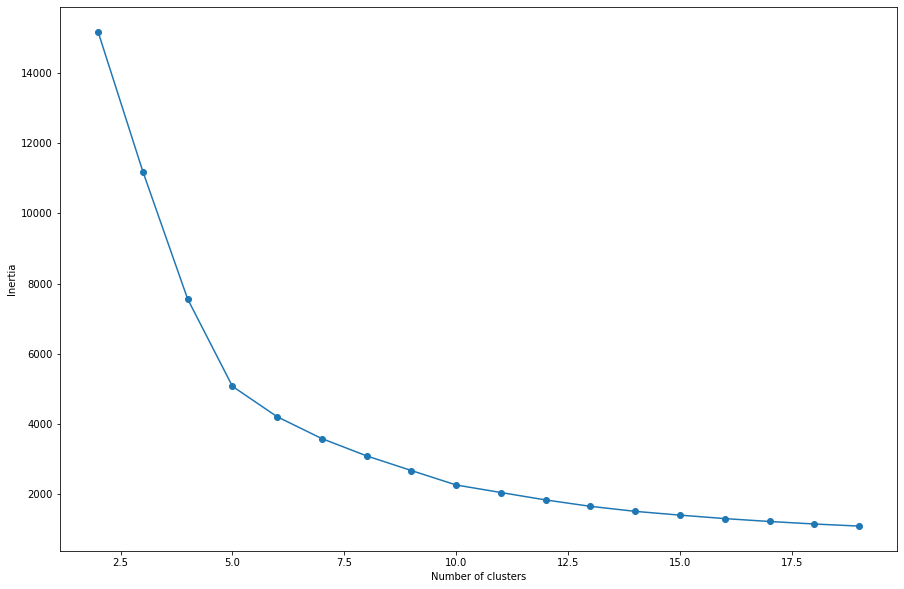

In [106]:
plt.figure(figsize=(15, 10))
plt.plot(K, dist, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Inertia gives a rough estimate for an optimal number of clusters. Sure, its better to have lesser inertia, but as the number of clusters grows - small inertia could also mean that we just split perfectly okay clusters into additional redundant ones. Inertia does not change much when you keep doing that - so we could say that around 7 clusters is fine - its where it stops changing much. But let us look into another metric, the Silhouette Score: 

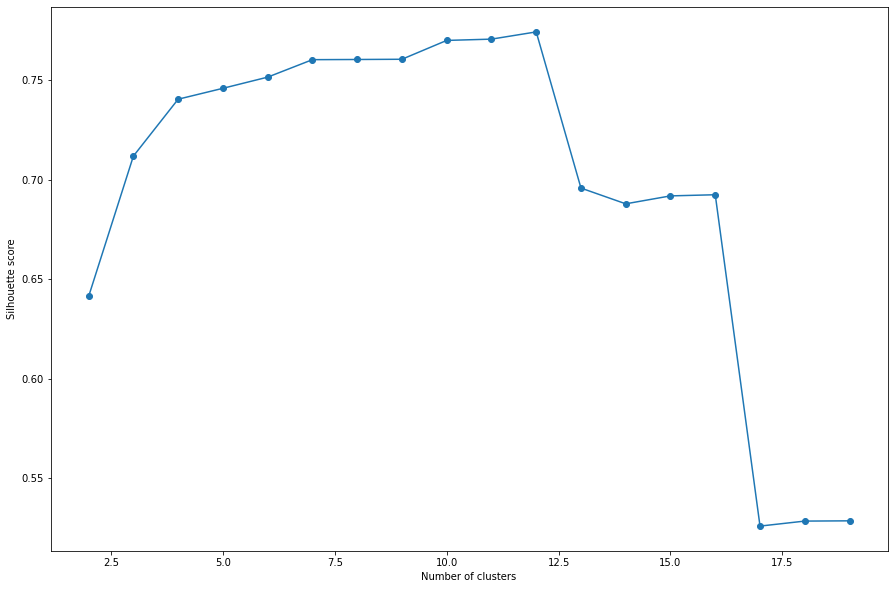

In [107]:
plt.figure(figsize=(15, 10))
plt.plot(K, silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

Closer to 1 values mean that the clusters are well-isolated. So we see that this metric also kind of saturates at around 6-7 clusters. 
Let us look at these seven clusters. Compute their sizes, and averages of each quantity.

In [124]:
model = KMeans(n_clusters=7, random_state=111, n_init=100, max_iter=20000)
model.fit(standard_data)
result_clear_labeled=result_clear.copy()
result_clear_labeled[f'{7}_clusters'] = model.labels_
print(result_clear_labeled.groupby(f'{7}_clusters')[standard_data.columns].mean())
print(result_clear_labeled.groupby(f'{7}_clusters')[standard_data.columns].size())

             sy_snum     pl_orbper    pl_bmasse    pl_rade
7_clusters                                                
0           1.000000     33.049466    11.854497   2.383945
1           1.000000    591.664980   573.066694  13.151994
2           2.135965     86.672358    24.109148   3.011825
3           1.400000  99010.803426  5209.382988  12.440000
4           1.110294   2331.210578  4579.148573  12.231390
5           1.086957  22329.791503  4258.963672  12.808761
6           2.155303    754.040197   800.132119  13.778511
7_clusters
0    3739
1    1084
2     228
3       5
4     136
5      46
6     264
dtype: int64


First of all we see two largest clusters: 0 and 1. They both correspond to planets in a system with one star. Cluster 0 clearly describes Earth-like planets, that are close to the star. The cluster 1 corresponds to giant and heavy planets - that orbit further from the star. There are clusters 2 and 6 corresponding to the systems with more than one star, and similar to the one star case, cluster 2 contains relatively small planets that orbit the star/s closely, and cluster 6 describes huge and heavy far-orbiting planets. Other, much smaller clusters 3,4,5 describe planets that don't fit: these are very heavy planets, that orbit far away from the star, however for some reason they all have approximately the same size (and are kind of small). 

We can visualize our clusters by plotting them in a 2D plane, say, orbital period vs. planet radius. We can make a 3D plot as well, but 2D is kind of more clear.  

As most of the clusters have  either exactly or almost exactly 1 star or 2 stars, we can separate the data by the number of stars. By doing that we would visualize the similarities between clusters 0,1 and 2,6. 

In [126]:
one_star = result_clear_labeled.loc[result_clear['sy_snum'] == 1]
multiple_stars = result_clear_labeled.loc[result_clear['sy_snum'] > 1]

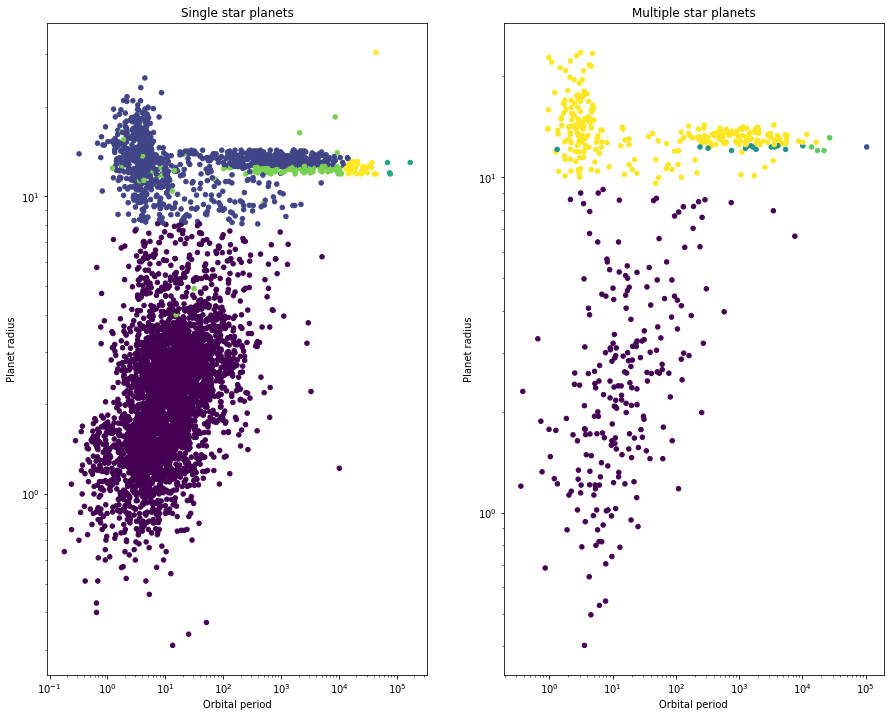

In [139]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15, 12))
ax1.scatter(one_star["pl_orbper"], one_star["pl_rade"], c=one_star[f'{7}_clusters'], alpha=1, s=20)
ax1.set_title('Single star planets')
ax2.scatter(multiple_stars["pl_orbper"], multiple_stars["pl_rade"], c=multiple_stars[f'{7}_clusters'],alpha=1, s=20)
ax2.set_title('Multiple star planets')
for ax in (ax1,ax2):
    ax.set(xlabel='Orbital period', ylabel='Planet radius')
    ax.set_xscale('log')
    ax.set_yscale('log')

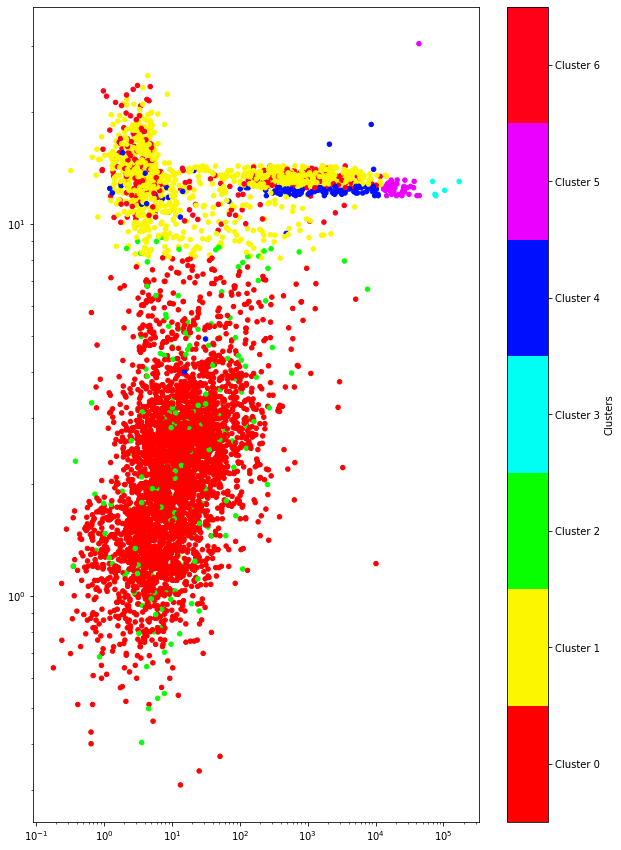

In [138]:
from matplotlib.colors import ListedColormap, BoundaryNorm


plt.figure(figsize=(10, 15))
cmap = plt.get_cmap('hsv', 7) 
norm = BoundaryNorm(np.arange(-0.5, 7.5), cmap.N) 

scatter=plt.scatter(result_clear_labeled["pl_orbper"], result_clear_labeled["pl_rade"], c=result_clear_labeled[f'{7}_clusters'], cmap=cmap,norm=norm, alpha=1, s=20)
plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(scatter)
cbar.set_label('Clusters')

# Set colorbar ticks to match categories
cbar.set_ticks(np.arange(0, 7)) 
cbar.set_ticklabels([f'Cluster {i}' for i in range(0, 7)])

From here we can visually distinguish different clusters, and we also see that planets with one and multiple stars have similar distribution, as we also noticed by looking at the numbers above. That implies that physics is also the same, and perhaps either most of the planets orbit only one of the stars (and the others are far enough so one can neglect their gravitational influence). Or it could be that planets orbit two or more stars, but the distance between the stars is much smaller than the radius of planet's orbit, so we can view the multiple stars as a single object (so then the physics is pretty much the same as in one-star systems). 


Let us look at the plot from [NASA](https://www.nasa.gov/image-feature/ames/kepler/exoplanet-populations) 
![title](planets.png) 

Let us look into the categories of planets they distinguish: 

**Hot jupiters** Hot Jupiters are a class of gas giant exoplanets that are inferred to be physically similar to Jupiter but that have very short orbital periods.  The Jupiter's mass is 318 times that of the Earth and the radius is around 11 times bigger.

**Cold Gas Giants** These are planets similar to Saturn and Jupiter in our Solar System. 

**Ocean Worlds & Ice Giants** These are planets similar to Neptun and Uranus. These are smaller than Saturn or Jupiter, but still quite big and heavy. For instance, the Uranus is about 14.5 heavier than the Earth, and its radius is around 4 times larger than the radius of our planet. 

**Rocky Planets, Lava Worlds** Those are the planets that are similar to the Earth.  Lava Worlds - are the Earth-like planets covered by lava partially or entirely. They orbit quite close to their star and are smaller than the Earth. 


We see, unfortunately, that our method was unable to distinguish between Hot Jupiters, Cold Gas Giants, Ocean Worlds, and Ice Giants. This is because some of these clusters do not have regular, spherical shapes and are stretched out along the Orbital Period axis, as illustrated in the figure above. The reason why we were unable to split them up to separate clusters is due to the metric that is used to estimate the performance of k-means. 

Note that splitting to larger number of clusters does not help to solve the problem. Increasing the number of clusters probably initiates the model to cut larger well-separated clusters into a few smaller ones. 

To understand this problem better, let us focus on the problematic cluster 1 only. 

In [150]:
cluster_1=result_clear_labeled[result_clear_labeled[f'{7}_clusters']==1][['pl_orbper','pl_bmasse','pl_rade']]

standard_1=pd.DataFrame(standard_scaler.fit_transform(cluster_1),
                             columns=['pl_orbper','pl_bmasse','pl_rade'])
print(standard_1)

      pl_orbper  pl_bmasse   pl_rade
0      0.221456   2.307402 -0.154215
1     -0.411356  -0.263854  0.196281
2     -0.123762  -0.377640  0.240093
3     -0.373998  -0.804881  0.021033
4     -0.110586   2.134513 -0.154215
...         ...        ...       ...
1079  -0.411351   0.862811  0.622133
1080   0.466475   1.313479 -0.066591
1081  -0.411968  -0.213660  1.113266
1082  -0.412531  -0.420030  0.523556
1083  -0.413654  -0.362023  1.186870

[1084 rows x 3 columns]


In [165]:
model1 = KMeans(n_clusters=4, random_state=111, n_init=100, max_iter=20000)
model1.fit(standard_1)
result1_clear_labeled=cluster_1.copy()
result1_clear_labeled[f'{3}_clusters'] = model1.labels_

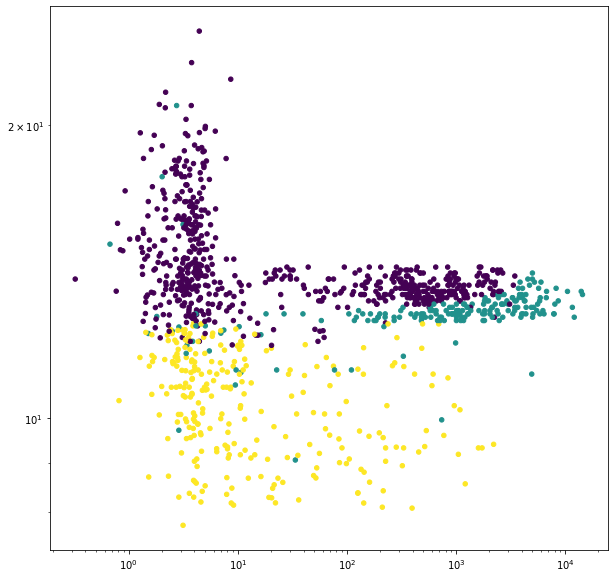

In [161]:
plt.figure(figsize=(10, 10))
scatter=plt.scatter(result1_clear_labeled["pl_orbper"], result1_clear_labeled["pl_rade"], c=result1_clear_labeled[f'{3}_clusters'], alpha=1, s=20)
plt.xscale('log')
plt.yscale('log')

So indeed, because the two clusters that we want to separate are indeed stretched, it is probably more optimal to split the larger clusters into smaller ones as we increase the number of clusters as this would give smaller inertia. Let us try different clustering method to try and solve this issue. Basically, we need to start with a model that has built in information about **shapes** of the clusters. In the simplest case, that can be achieved by using a modified version of the k-means algorithm, **Gaussian Mixture**. 

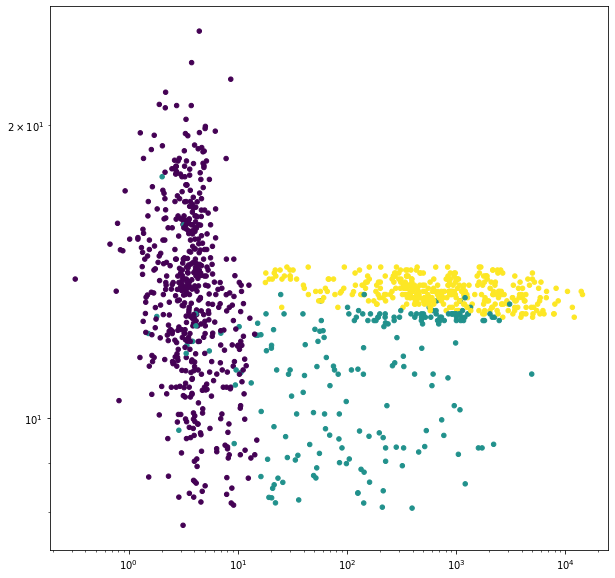

In [162]:
from sklearn.mixture import GaussianMixture
plt.figure(figsize=(10, 10))
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(standard_1)
result1_clear_labeled_gm=cluster_1.copy()
result1_clear_labeled_gm['labels_gm']=gm.predict(standard_1)

scatter1_gm=plt.scatter(result1_clear_labeled_gm["pl_orbper"], result1_clear_labeled_gm["pl_rade"], c=result1_clear_labeled_gm['labels_gm'], alpha=1, s=20)
plt.xscale('log')
plt.yscale('log')

This worked out quite well! 

## Selecting principal components (PCA)

In [178]:
from sklearn.decomposition import PCA

n_comp=len(standard_data.columns)
Reduced=PCA(n_components=n_comp-2) #so this is 3 in our case
Reduced_fit=Reduced.fit_transform(standard_data)

Text(0, 0.5, 'Second component')

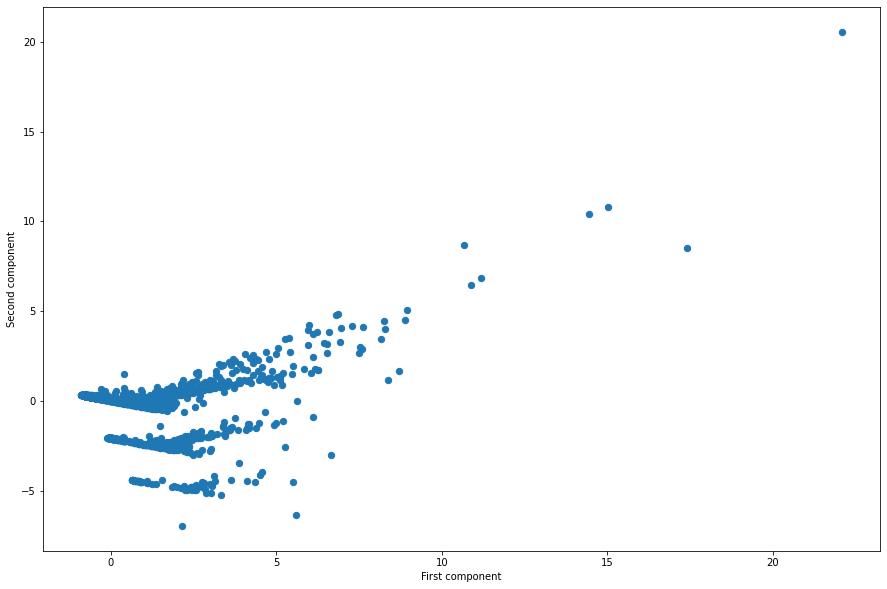

In [179]:
plt.figure(figsize=(15, 10))
plt.scatter(Reduced_fit[:, 0],Reduced_fit[:, 1], alpha = 1, s =40)
plt.xlabel('First component')
plt.ylabel('Second component')

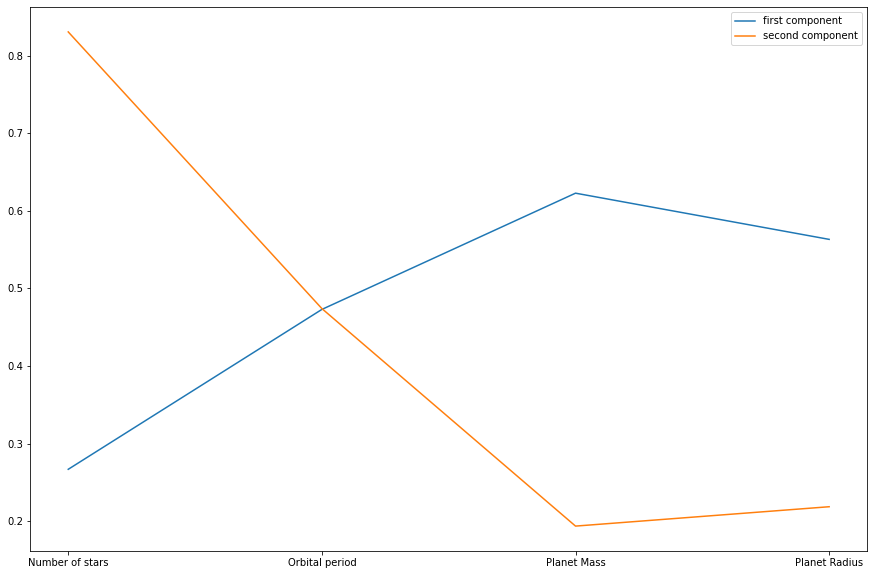

In [181]:
plt.figure(figsize=(15, 10))
list_param=['Number of stars','Orbital period','Planet Mass','Planet Radius']
plt.plot(list_param,np.abs(Reduced.components_[0]),label='first component')
plt.plot(list_param,np.abs(Reduced.components_[1]),label='second component')
plt.legend()

In [185]:
print(f"Variance ratio:{Reduced.explained_variance_ratio_}", f"\nVectors:{Reduced.components_}")

Variance ratio:[0.43833615 0.25234895] 
Vectors:[[ 0.2668506   0.47294684  0.62279128  0.56324335]
 [-0.830671    0.4740302   0.19363993 -0.21859697]]


# Interpretation of principal components

What is the meaning of the two principle components? 

We see that the first component mostly depends on information about orbital period, mass, and radius of a planet. 
The second component depends mostly on the number of stars and orbital period. 

We can interpret the first component as a parameter related to the characteristics of a planet as an individual entity. In contrast, the second component reflects characteristics of the planetary system as a whole. Interestingly, the orbital period contributes almost equally to both components, likely because it is influenced by both the planet’s individual attributes, such as mass and radius, and the system's characteristics, including the number of planets and stars in the system and their features. 
